In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b/glove.6B.200d.txt
/kaggle/input/glove6b/glove.6B.50d.txt
/kaggle/input/glove6b/glove.6B.300d.txt
/kaggle/input/glove6b/glove.6B.100d.txt
/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [5]:
#import useful libraries
import keras
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#download stopwords from nltk
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [7]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
#read dataset
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

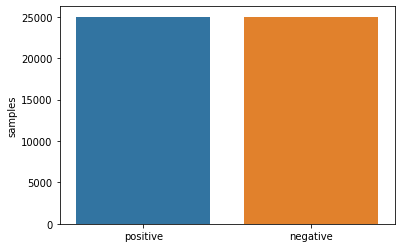

In [9]:
#check the distribution of the positive and negative review
x = df['sentiment'].value_counts()
sns.barplot(x.index, x)
plt.ylabel('samples')

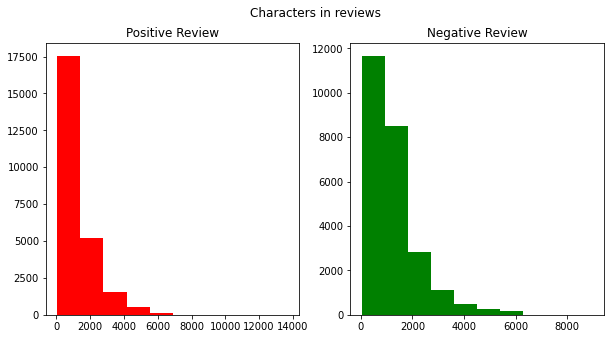

In [10]:
#see how many characters are in the reviews
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
review_len=df[df['sentiment']=='positive']['review'].astype(str).str.len()
ax1.hist(review_len,color='red')
ax1.set_title('Positive Review')
review_len=df[df['sentiment']=='negative']['review'].astype(str).str.len()
ax2.hist(review_len,color='green')
ax2.set_title('Negative Review')
fig.suptitle('Characters in reviews')
plt.show()

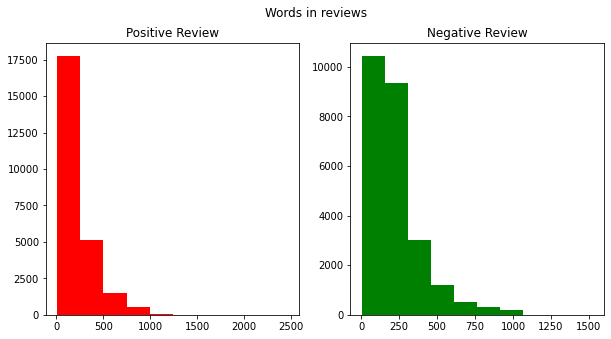

In [11]:
#see how many words are in the reviews
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
review_len=df[df['sentiment']=='positive']['review'].astype(str).str.split().map(lambda x: len(x))
ax1.hist(review_len,color='red')
ax1.set_title('Positive Review')
review_len=df[df['sentiment']=='negative']['review'].astype(str).str.split().map(lambda x: len(x))
ax2.hist(review_len,color='green')
ax2.set_title('Negative Review')
fig.suptitle('Words in reviews')
plt.show()

In [19]:
#define some functions to clean the review
def lower_case(text):
    return text.lower()

def remove_tag(text):
    tag = re.compile(r'<.*?>')
    return tag.sub(r'', text)

def remove_number(text):
    num = re.compile(r'[\d]')
    return num.sub(r'', text)
    
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    return text

def remove_punct(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def clean_text(text):
    text = lower_case(text)
    text = remove_tag(text)
    text = remove_number(text)
    text = remove_punct(text)
    text = remove_stopwords(text)
    return text

In [20]:
df['clean_review'] = df['review'].apply(clean_text)
df.head()

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode yo...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [21]:
reviews = df['clean_review']
reviews

0        one reviewers mentioned watching oz episode yo...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically theres family little boy jake thinks...
4        petter matteis love time money visually stunni...
                               ...                        
49995    thought movie right good job wasnt creative or...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary schools n...
49998    im going disagree previous comment side maltin...
49999    one expects star trek movies high art fans exp...
Name: clean_review, Length: 50000, dtype: object

In [26]:
reviews_list = []
for i in range(len(reviews)):
    reviews_list.append(reviews[i])

In [27]:
sentiment = df['sentiment']
y = np.array(list(map(lambda x: 1 if x == 'positive' else 0, sentiment)))
y

array([1, 1, 1, ..., 0, 0, 0])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(reviews_list, y, test_size = 0.2)

In [29]:
len(y_train)

40000

In [31]:
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(X_train)

In [35]:
words_to_index = tokenizer.word_index
len(words_to_index)

187074

In [37]:
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding = 'UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype = np.float64)
    
    return word_to_vec_map

In [39]:
word_to_vec_map = read_glove_vector('/kaggle/input/glove6b/glove.6B.300d.txt')

In [51]:
maxLen = 150
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['a'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))
print('The shape of the embedded matrix is ', emb_matrix.shape)

for word, i in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[i, :] = embedding_vector

The shape of the embedded matrix is  (187074, 300)


In [52]:
embedding_layer = Embedding(input_dim = vocab_len, output_dim = embed_vector_len, input_length = maxLen, weights = [emb_matrix], trainable = False)

In [61]:
def imdb_rating(input_shape):
    X_indices = Input(input_shape)
    embeddings = embedding_layer(X_indices)
    X = LSTM(128, return_sequences = True)(embeddings)
    X = Dropout(0.6)(X)
    X = LSTM(128, return_sequences = True)(X)
    X = Dropout(0.6)(X)
    X = LSTM(128)(X)
    X = Dense(1, activation = 'sigmoid')(X)
    model = Model(inputs = X_indices, outputs = X)
    
    return model

In [59]:
X_train_indices = tokenizer.texts_to_sequences(X_train)
X_train_indices = pad_sequences(X_train_indices, maxlen = maxLen, padding = 'post')

In [62]:
model = imdb_rating(maxLen)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train_indices, y_train, batch_size = 64, epochs = 20)

Epoch 1/20
625/625 [==============================] - 399s 630ms/step - loss: 0.6756 - accuracy: 0.5613
Epoch 2/20
625/625 [==============================] - 393s 629ms/step - loss: 0.6821 - accuracy: 0.5145
Epoch 3/20
625/625 [==============================] - 394s 631ms/step - loss: 0.6654 - accuracy: 0.5743
Epoch 4/20
625/625 [==============================] - 401s 642ms/step - loss: 0.6919 - accuracy: 0.5099
Epoch 5/20
625/625 [==============================] - 393s 629ms/step - loss: 0.6812 - accuracy: 0.5573
Epoch 6/20
625/625 [==============================] - 392s 628ms/step - loss: 0.5772 - accuracy: 0.7096
Epoch 7/20
625/625 [==============================] - 392s 627ms/step - loss: 0.4124 - accuracy: 0.8236
Epoch 8/20
625/625 [==============================] - 391s 626ms/step - loss: 0.3425 - accuracy: 0.8559
Epoch 9/20
625/625 [==============================] - 395s 632ms/step - loss: 0.3203 - accuracy: 0.8646
Epoch 10/20
625/625 [==============================] - 396s 633m

In [65]:
X_test_indices = tokenizer.texts_to_sequences(X_test)
X_test_indices = pad_sequences(X_test_indices, maxlen = maxLen, padding = 'post')

In [66]:
model.evaluate(X_test_indices, y_test)

313/313 [==============================] - 61s 192ms/step - loss: 0.4896 - accuracy: 0.8684


[0.48962125182151794, 0.868399977684021]